In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
from tqdm import tqdm
import requests
from urllib.parse import urlparse
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import datetime
from sklearn.preprocessing import quantile_transform
pd.options.mode.chained_assignment = None  # default='warn'
import gc
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
font_path = './NanumFontSetup_TTF_BARUNGOTHIC/NanumBarunGothic.ttf'
import matplotlib.font_manager as fm
fontprop = fm.FontProperties(fname=font_path, size=18)
import seaborn as sns
import shap

In [2]:
%%time
# Read Data
basedir = './Training/training_data_ver_16/'
training_data_df = pd.read_csv(basedir + 'training_data_ver_16.csv').drop(columns=['주택가격지수']).dropna()
#training_data_df = training_data_df[(training_data_df['가격면적'] >= 200) & (training_data_df['가격면적'] <= 1500)]
training_data_df.columns = [col.replace(' ','_').replace('·','_') for col in training_data_df.columns]

Wall time: 1min 25s


In [3]:
training_data_df = training_data_df[(training_data_df['가격면적'] >= 200) & (training_data_df['가격면적'] <= 3000)]

In [4]:
training_data_df['호수대비부속건축물면적'] = training_data_df['부속건축물면적'] / training_data_df['총호수']

In [5]:
training_data_df = training_data_df[(training_data_df['호수대비부속건축물면적'] < 100)]

In [6]:
training_data_df = training_data_df.reset_index(drop=True)

In [7]:
cols_to_log = ['총건축면적', '총연면적', '총용적률연면적', '토지면적', '부속건축물면적']
for col in cols_to_log:
    training_data_df[col] = training_data_df[col].apply(np.log1p)

In [8]:
cat_cols_df = pd.read_csv(basedir + 'cat_cols.csv')

In [9]:
cat_cols_list = [col.replace(' ','_').replace('·','_') for col in cat_cols_df['colname'].tolist()]
len(cat_cols_list)

296

In [10]:
cat_cols = [col for col in training_data_df.columns if col in cat_cols_list]
len(cat_cols)

296

In [11]:
cat_cols[:10]

['건물나이',
 'trade_type',
 '표준지여부',
 '지목명',
 '용도지역명1',
 '용도지역명2',
 '토지이동상황',
 '지형높이',
 '지형형상',
 '도로접면']

In [15]:
shap_summary_df = pd.read_csv(basedir + 'shap_top_50.csv', index_col=[0]).sort_values(['shap_summary_mean'], ascending=False)
print(shap_summary_df.shape)
shap_summary_df.head()

(50, 6)


,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
trade_type,94.786912,91.486465,94.241243,95.729807,88.752225,92.999330
공시지가(만원),75.491478,76.576388,79.027518,76.699474,77.195120,76.997996
year_linear,62.870904,63.194284,65.265465,63.662020,62.827286,63.563992
건축년도,48.793829,46.055976,51.575884,49.885488,47.973356,48.856907
전용면적,38.680787,37.920969,38.424582,40.406961,38.533988,38.793457


In [16]:
shap_summary_df.tail(50)

,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
trade_type,94.786912,91.486465,94.241243,95.729807,88.752225,92.999330
공시지가(만원),75.491478,76.576388,79.027518,76.699474,77.195120,76.997996
year_linear,62.870904,63.194284,65.265465,63.662020,62.827286,63.563992
건축년도,48.793829,46.055976,51.575884,49.885488,47.973356,48.856907
전용면적,38.680787,37.920969,38.424582,40.406961,38.533988,38.793457
ynorm,30.764362,29.730660,31.158611,30.951121,31.525356,30.826022
xy,23.042329,21.686652,20.119934,21.468469,19.954026,21.254282
x_2nd,20.670054,18.346814,20.318013,20.426533,20.779275,20.108138
주건축물수,13.617734,13.459746,13.675589,13.631617,13.493223,13.575582
층mean,10.282975,11.031003,10.171245,10.349117,11.455565,10.657981


In [17]:
top_49_df = shap_summary_df.iloc[:49,:]
print(top_49_df.shape)

(49, 6)


In [18]:
top_49_df.head()

,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
trade_type,94.786912,91.486465,94.241243,95.729807,88.752225,92.999330
공시지가(만원),75.491478,76.576388,79.027518,76.699474,77.195120,76.997996
year_linear,62.870904,63.194284,65.265465,63.662020,62.827286,63.563992
건축년도,48.793829,46.055976,51.575884,49.885488,47.973356,48.856907
전용면적,38.680787,37.920969,38.424582,40.406961,38.533988,38.793457


In [19]:
top_49_df.tail(20)

,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
지형높이,2.588395,2.239442,2.518641,2.525001,2.149860,2.404268
건물나이,2.325564,2.295965,2.349993,2.485902,2.231466,2.337778
month_sin,2.297559,2.206871,2.110062,2.312452,2.284165,2.242222
층min,2.233266,2.113161,2.130597,2.204436,2.380049,2.212302
옥외자주식대수,1.967414,2.374677,2.036804,1.924878,2.272678,2.115290
(한강)폐기물매립시설_설치제한지역,2.073255,1.933298,1.985423,1.932315,1.936087,1.972076
공원,2.052903,2.387582,1.834157,1.776152,1.730321,1.956223
지형형상,1.346699,1.487353,1.382426,1.277778,1.281873,1.355226
y_cos,1.290260,1.357465,1.168953,1.366032,1.102780,1.257098
x_sin,1.190774,1.217717,1.140458,1.367279,1.207240,1.224694


In [20]:
target_cols = ['금액(만원)', '가격면적', 'target_log_transformed', 'targetarea_log_transformed', '지번주소']

In [21]:
training_data_df = training_data_df[top_49_df.index.tolist()+target_cols]
print(training_data_df.shape)
training_data_df.head()

(3658226, 54)


,trade_type,공시지가(만원),year_linear,건축년도,전용면적,ynorm,xy,x_2nd,주건축물수,층mean,총건축면적,호수대비연면적,아파트지구,토지이동상황,xnorm,호수대비부속건축물면적,옥내자주식대수,층,총호수,호수대비주차수,y_2nd,용도지역명1,층norm,지구단위계획구역,가축사육제한구역,부속건축물수,도로접면,부속건축물면적,지붕_평지붕_fraction,지형높이,건물나이,month_sin,층min,옥외자주식대수,(한강)폐기물매립시설_설치제한지역,공원,지형형상,y_cos,x_sin,x_cos,y_sin,상대정화구역,정비구역,제3종일반주거지역,제1종지구단위계획구역,중점경관관리구역,제2종일반주거지역,총외필지수,옥내기계식대수,금액(만원),가격면적,target_log_transformed,targetarea_log_transformed,지번주소
0,0,921.0,7.666667,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,1.0,9.0,6.27131,98.537963,0,0,5579.095707,0.0,0.0,2,54.0,0.0,4.094180e+07,0,0.222222,0,0,0.0,0,0.0,1.0,0,0,-0.866025,9.0,0.0,0,0,0,0.390815,-0.364267,0.931294,-0.920469,0,0,0,0,0,0,1.0,0.0,57000.0,733.118971,10.950807,6.597308,서울특별시 강남구 개포동 655-2
1,0,921.0,7.916667,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,1.0,9.0,6.27131,98.537963,0,0,5579.095707,0.0,0.0,2,54.0,0.0,4.094180e+07,0,0.222222,0,0,0.0,0,0.0,1.0,0,0,-0.500000,9.0,0.0,0,0,0,0.390815,-0.364267,0.931294,-0.920469,0,0,0,0,0,0,1.0,0.0,57000.0,733.118971,10.950807,6.597308,서울특별시 강남구 개포동 655-2
2,1,921.0,7.000000,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,1.0,9.0,6.27131,98.537963,0,0,5579.095707,0.0,0.0,4,54.0,0.0,4.094180e+07,0,0.444444,0,0,0.0,0,0.0,1.0,0,0,0.000000,9.0,0.0,0,0,0,0.390815,-0.364267,0.931294,-0.920469,0,0,0,0,0,0,1.0,0.0,35000.0,450.160772,10.463103,6.109605,서울특별시 강남구 개포동 655-2
3,1,921.0,7.166667,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,1.0,9.0,6.27131,98.537963,0,0,5579.095707,0.0,0.0,9,54.0,0.0,4.094180e+07,0,1.000000,0,0,0.0,0,0.0,1.0,0,0,0.866025,9.0,0.0,0,0,0,0.390815,-0.364267,0.931294,-0.920469,0,0,0,0,0,0,1.0,0.0,32000.0,411.575563,10.373491,6.019993,서울특별시 강남구 개포동 655-2
4,1,921.0,7.666667,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,1.0,9.0,6.27131,98.537963,0,0,5579.095707,0.0,0.0,1,54.0,0.0,4.094180e+07,0,0.111111,0,0,0.0,0,0.0,1.0,0,0,-0.866025,9.0,0.0,0,0,0,0.390815,-0.364267,0.931294,-0.920469,0,0,0,0,0,0,1.0,0.0,37000.0,475.884244,10.518673,6.165175,서울특별시 강남구 개포동 655-2


# Training

In [22]:
from sklearn.model_selection import KFold, GroupKFold

In [23]:
import lightgbm as lgb

In [24]:
from sklearn.metrics import r2_score

In [25]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [26]:
cat_cols = [col for col in cat_cols if col in training_data_df.columns.tolist()]
len(cat_cols)

18

In [27]:
# Next things to do:
# 1. Do Variance Inflation Factor (VIF) analysis.
# 2. keep the feature with the highest shap value
# 3. Retrain
# 4. Remove 1 feature at a time and find out the set of feature with the lowest loss.
# 5. Retrain
# 6. Continue production prep

Fold 0 start
(2926580, 49)
y dist plot


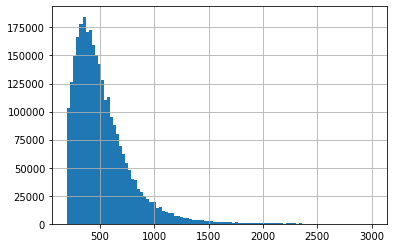

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.180855 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6136
[LightGBM] [Info] Number of data points in the train set: 2926580, number of used features: 49


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.640869
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.5819
[100]	valid_0's huber: 64.8789
[150]	valid_0's huber: 58.7769
[200]	valid_0's huber: 55.1414
[250]	valid_0's huber: 52.5342
[300]	valid_0's huber: 50.8336
[350]	valid_0's huber: 49.5946
[400]	valid_0's huber: 48.4079
[450]	valid_0's huber: 47.4499
[500]	valid_0's huber: 46.7243
[550]	valid_0's huber: 46.0273
[600]	valid_0's huber: 45.3244
[650]	valid_0's huber: 44.7489
[700]	valid_0's huber: 44.2165
[750]	valid_0's huber: 43.7548
[800]	valid_0's huber: 43.334
[850]	valid_0's huber: 42.8833
[900]	valid_0's huber: 42.5449
[950]	valid_0's huber: 42.1954
[1000]	valid_0's huber: 41.8644
[1050]	valid_0's huber: 41.5831
[1100]	valid_0's huber: 41.3015
[1150]	valid_0's huber: 41.0335
[1200]	valid_0's huber: 40.7859
[1250]	valid_0's huber: 40.5575
[1300]	valid_0's huber: 40.3467
[1350]	valid_0's huber: 40.1426
[1400]	valid_0's huber: 39.9354
[1450]	v

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


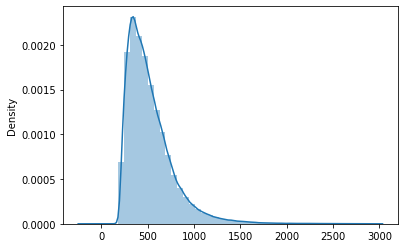

Fold 0 end
Fold 1 start
(2926581, 49)
y dist plot


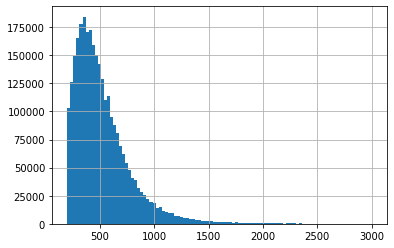

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.166001 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6134
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 49


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.755320
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.6868
[100]	valid_0's huber: 65.0106
[150]	valid_0's huber: 58.7036
[200]	valid_0's huber: 54.8771
[250]	valid_0's huber: 52.2867
[300]	valid_0's huber: 50.5977
[350]	valid_0's huber: 49.1318
[400]	valid_0's huber: 48.0421
[450]	valid_0's huber: 47.0868
[500]	valid_0's huber: 46.2986
[550]	valid_0's huber: 45.6322
[600]	valid_0's huber: 45.0623
[650]	valid_0's huber: 44.4889
[700]	valid_0's huber: 44.0478
[750]	valid_0's huber: 43.5968
[800]	valid_0's huber: 43.1391
[850]	valid_0's huber: 42.6916
[900]	valid_0's huber: 42.3374
[950]	valid_0's huber: 42.03
[1000]	valid_0's huber: 41.7152
[1050]	valid_0's huber: 41.3671
[1100]	valid_0's huber: 41.0794
[1150]	valid_0's huber: 40.7723
[1200]	valid_0's huber: 40.5115
[1250]	valid_0's huber: 40.2753
[1300]	valid_0's huber: 40.0521
[1350]	valid_0's huber: 39.8733
[1400]	valid_0's huber: 39.6778
[1450]	va

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


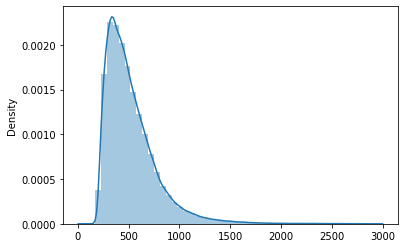

Fold 1 end
Fold 2 start
(2926581, 49)
y dist plot


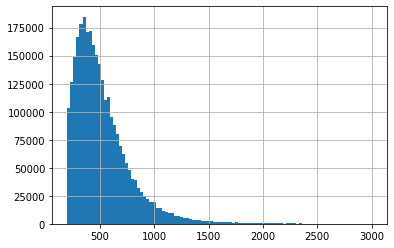

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.190744 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6137
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 49


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.648130
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.481
[100]	valid_0's huber: 64.5859
[150]	valid_0's huber: 58.5664
[200]	valid_0's huber: 54.7988
[250]	valid_0's huber: 52.4892
[300]	valid_0's huber: 50.7487
[350]	valid_0's huber: 49.3597
[400]	valid_0's huber: 48.2943
[450]	valid_0's huber: 47.2533
[500]	valid_0's huber: 46.4369
[550]	valid_0's huber: 45.7068
[600]	valid_0's huber: 45.001
[650]	valid_0's huber: 44.4742
[700]	valid_0's huber: 43.9627
[750]	valid_0's huber: 43.5337
[800]	valid_0's huber: 43.096
[850]	valid_0's huber: 42.7359
[900]	valid_0's huber: 42.3507
[950]	valid_0's huber: 42.002
[1000]	valid_0's huber: 41.6971
[1050]	valid_0's huber: 41.3865
[1100]	valid_0's huber: 41.0968
[1150]	valid_0's huber: 40.8172
[1200]	valid_0's huber: 40.5858
[1250]	valid_0's huber: 40.343
[1300]	valid_0's huber: 40.1303
[1350]	valid_0's huber: 39.9243
[1400]	valid_0's huber: 39.7611
[1450]	valid

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


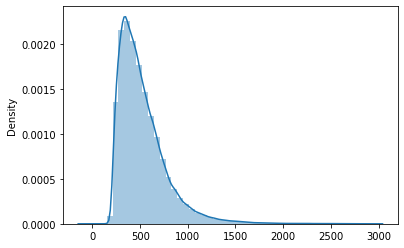

Fold 2 end
Fold 3 start
(2926581, 49)
y dist plot


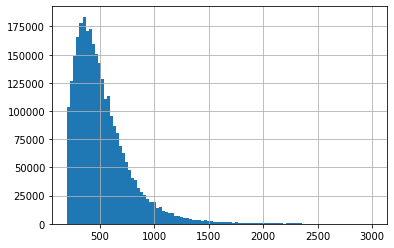

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.178591 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6131
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 49


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.732369
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.5235
[100]	valid_0's huber: 64.7379
[150]	valid_0's huber: 58.7284
[200]	valid_0's huber: 55.0585
[250]	valid_0's huber: 52.4771
[300]	valid_0's huber: 50.7303
[350]	valid_0's huber: 49.2987
[400]	valid_0's huber: 48.1947
[450]	valid_0's huber: 47.2638
[500]	valid_0's huber: 46.574
[550]	valid_0's huber: 45.8652
[600]	valid_0's huber: 45.19
[650]	valid_0's huber: 44.5892
[700]	valid_0's huber: 44.0256
[750]	valid_0's huber: 43.5459
[800]	valid_0's huber: 43.0479
[850]	valid_0's huber: 42.641
[900]	valid_0's huber: 42.2903
[950]	valid_0's huber: 41.9591
[1000]	valid_0's huber: 41.6296
[1050]	valid_0's huber: 41.3251
[1100]	valid_0's huber: 41.0663
[1150]	valid_0's huber: 40.7868
[1200]	valid_0's huber: 40.5294
[1250]	valid_0's huber: 40.2951
[1300]	valid_0's huber: 40.0938
[1350]	valid_0's huber: 39.8882
[1400]	valid_0's huber: 39.6915
[1450]	vali

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


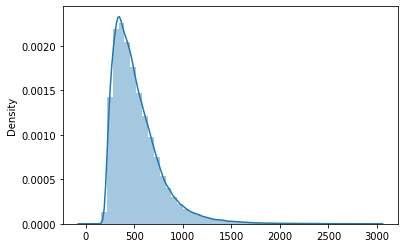

Fold 3 end
Fold 4 start
(2926581, 49)
y dist plot


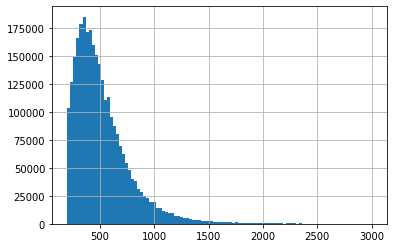

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.159498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6131
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 49


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.646665
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.4209
[100]	valid_0's huber: 64.6336
[150]	valid_0's huber: 58.6688
[200]	valid_0's huber: 55.1425
[250]	valid_0's huber: 52.6133
[300]	valid_0's huber: 50.8101
[350]	valid_0's huber: 49.4098
[400]	valid_0's huber: 48.3241
[450]	valid_0's huber: 47.2748
[500]	valid_0's huber: 46.3403
[550]	valid_0's huber: 45.7501
[600]	valid_0's huber: 45.0975
[650]	valid_0's huber: 44.5436
[700]	valid_0's huber: 44.0441
[750]	valid_0's huber: 43.5517
[800]	valid_0's huber: 43.0868
[850]	valid_0's huber: 42.7024
[900]	valid_0's huber: 42.3276
[950]	valid_0's huber: 42.0159
[1000]	valid_0's huber: 41.7221
[1050]	valid_0's huber: 41.4282
[1100]	valid_0's huber: 41.1493
[1150]	valid_0's huber: 40.8819
[1200]	valid_0's huber: 40.6234
[1250]	valid_0's huber: 40.3696
[1300]	valid_0's huber: 40.1366
[1350]	valid_0's huber: 39.9447
[1400]	valid_0's huber: 39.7508
[1450]	

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


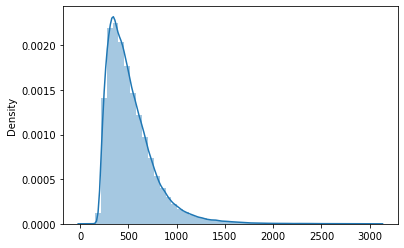

Fold 4 end


<Figure size 432x288 with 0 Axes>

In [28]:
count = 0
oof = np.zeros(training_data_df.shape[0])

shap_summary_df = pd.DataFrame()

for train_idx, val_idx in kf.split(training_data_df):
    print('Fold {} start'.format(count))
    train_data = training_data_df.loc[train_idx]
    val_data = training_data_df.loc[val_idx]
    
    x_train = train_data.drop(columns=target_cols)
    y_train = train_data['가격면적']
    
    print(x_train.shape)
    
    x_val = val_data.drop(columns=target_cols)
    y_val = val_data['가격면적']
    
    print('y dist plot')
    y_train.hist(bins=100)
    plt.show()
    plt.clf()
    
    params = {
        'objective': 'huber',
        'learning_rate': 10,
        'seed': 42,
        'max_depth': 12,
        'num_leaves': 37,
        'lambda_l2': 0,
        'metric': 'huber',
        'num_threads': 6,
    }
    
    train_dataset = lgb.Dataset(x_train, label=y_train, categorical_feature=cat_cols)
    val_dataset = lgb.Dataset(x_val, label=y_val, categorical_feature=cat_cols)
    
    num_rounds = 10000

    bst = lgb.train(params, train_dataset, num_rounds, valid_sets=[val_dataset], early_stopping_rounds=500, verbose_eval=50)
    
    bst.save_model(basedir + 'lightgbm_huber_shap_top_49_{}.txt'.format(count), num_iteration=bst.best_iteration)
    
    preds = bst.predict(x_val, num_iteration=bst.best_iteration)
    
    print('preds dist plot')
    sns.distplot(preds)
    plt.show()
    plt.clf()
    
    oof[val_idx] = preds
    
    # shap
    explainer = shap.explainers.Tree(bst)
    
    sample_x = x_val.sample(n=1000)
    sample_y = y_val.loc[x_val.index]
    
    shap_values = explainer.shap_values(sample_x, y=sample_y, check_additivity=True, approximate=False)
    shap_values_T = shap_values.T
    
    shap_summary = np.zeros(x_val.shape[1])
    
    for i in range(x_val.shape[1]):
        shap_summary[i] = np.mean(np.abs(shap_values_T[i]))
    
    
    shap_summary_df['model_{}_shap_summary'.format(count)] = shap_summary
        
    
    print('Fold {} end'.format(count))
    count += 1

In [29]:
from sklearn.metrics import mean_squared_error

In [30]:
np.sqrt(mean_squared_error(training_data_df['가격면적'], oof))

64.68343286055288

In [31]:
shap_summary_mean = np.zeros(shap_summary_df.shape[0])
for i in range(shap_summary_df.shape[1]):
    shap_summary_mean += shap_summary_df.iloc[:,i]

In [32]:
shap_summary_mean = shap_summary_mean / shap_summary_df.shape[1]

In [33]:
shap_summary_df['shap_summary_mean'] = shap_summary_mean

In [34]:
shap_summary_df.index = x_train.columns

In [35]:
shap_summary_df.to_csv(basedir + 'shap_top_49.csv')

In [36]:
#